In [31]:
using LinearAlgebra
using Distributions
using Plots

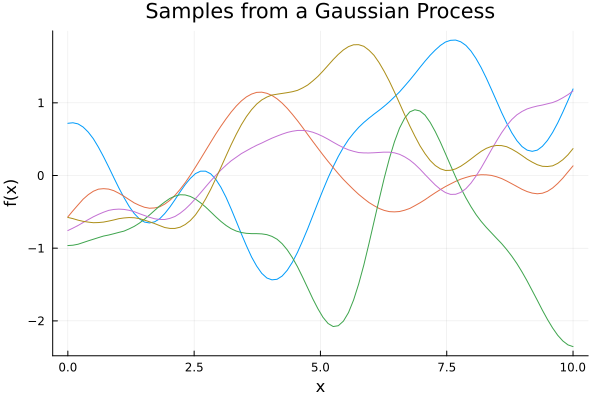

In [13]:
using Distributions
using Plots

# Define RBF kernel function
function rbf_kernel(x1, x2, σ²=0.5, ℓ=1.5)
    return σ² * exp(- (x1 - x2)^2 / (2 * ℓ^2))
end

# Function to sample and plot a variable number of samples from the GP
function plot_gp_samples(n_samples::Int, n_points=100, σ²=1.0, ℓ=1.0, jitter=1e-6)
    # Generate points
    x = range(0, stop=10, length=n_points)

    # Create covariance matrix with jitter
    K = [rbf_kernel(x[i], x[j], σ², ℓ) for i in 1:n_points, j in 1:n_points]
    K += I * jitter  # Add jitter to the diagonal

    # Mean vector (usually zeros for a GP prior)
    μ = zeros(n_points)
    
    # Initialize the plot
    gp_sample = rand(MvNormal(μ, K))
    p=plot(x, gp_sample, lw=1, label="Sample 1", xlabel="x", ylabel="f(x)", title="Samples from a Gaussian Process",legend=false)
    
    # Plot each sample
    for i in 2:n_samples
        gp_sample = rand(MvNormal(μ, K))
        plot!(p, x, gp_sample, lw=1, label="Sample $i")  # Use label="Sample $i" for each sample
    end
    return p  # Optionally return the plot object
end

# Call the function with a variable number of samples
plot_gp_samples(5)  # For example, 5 samples


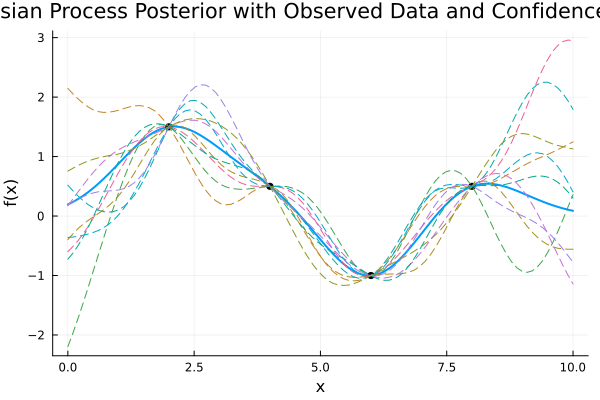

In [32]:
using Distributions, LinearAlgebra, Plots

# Define RBF kernel function
function rbf_kernel(x1, x2, σ²=0.5, ℓ=1.5)
    return σ² * exp(- (x1 - x2)^2 / (2 * ℓ^2))
end

function squared_exponential_with_kronecker(x1, x2, σ²=0.5, ℓ=1.5)
    delta = ifelse(x1 == x2, 1.0, 0.0)  # Kronecker delta term (1 if x1 == x2, 0 otherwise)
    return (1 - σ²) * exp(- (x1 - x2)^2 / (2 * ℓ^2)) + σ² * delta
end


# Observed data points
X_obs = [2.0, 4.0, 6.0, 8.0]  # Observed x-values
y_obs = [1.5, 0.5, -1.0, 0.5]  # Observed y-values

# Points where we want to make predictions
X_new = range(0, stop=10, length=100) |> collect

# Define GP kernel parameters
σ² = 1.0  # Variance
ℓ = 1.0   # Length scale

# Covariance matrices for observed data and new points
K_obs = [rbf_kernel(xi, xj, σ², ℓ) for xi in X_obs, xj in X_obs]
K_obs_new = [rbf_kernel(xi, xj, σ², ℓ) for xi in X_new, xj in X_obs]
K_new = [rbf_kernel(xi, xj, σ², ℓ) for xi in X_new, xj in X_new]

# Add jitter to K_obs to make it positive definite
jitter = 1e-6
K_obs += I * jitter

# Compute posterior mean and covariance
K_obs_inv = inv(K_obs)  # Inverse of the observed covariance matrix
posterior_mean = K_obs_new * K_obs_inv * y_obs
posterior_cov = K_new - K_obs_new * K_obs_inv * K_obs_new'

# Symmetrize and add jitter to posterior covariance for stability
posterior_cov = (posterior_cov + posterior_cov') / 2 + I * jitter

# Draw 10 samples from the posterior
n_samples = 10
posterior_samples = rand(MvNormal(posterior_mean, posterior_cov), n_samples)

# Calculate standard deviation for confidence interval shading
std_dev = sqrt.(Diagonal(posterior_cov))  # Access the diagonal and take sqrt

# Plot the GP posterior with confidence interval
plot(X_new, posterior_mean, label="Posterior Mean", lw=2, legend=false)
#plot!(X_new, posterior_mean .+ std_dev, fillrange=posterior_mean .- std_dev, fillalpha=0.2, label="95% Confidence Interval")
scatter!(X_obs, y_obs, label="Observed Data", color=:black, marker=:circle, ms=4)

# Plot the 10 sample functions
for i in 1:n_samples
    plot!(X_new, posterior_samples[:, i], lw=1, label="", linestyle=:dash)
end

xlabel!("x")
ylabel!("f(x)")
title!("Gaussian Process Posterior with Observed Data and Confidence Interval")


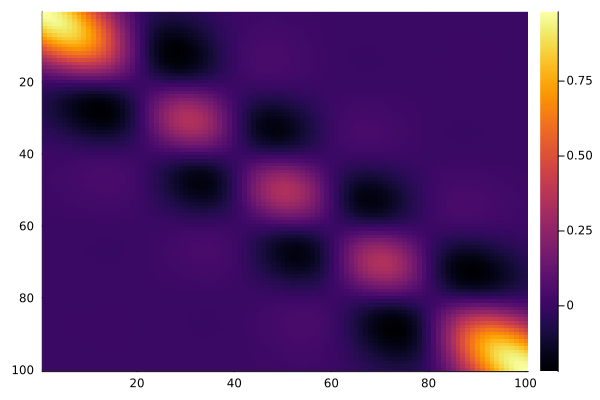

In [ ]:
heatmap(posterior_cov, yflip=true)

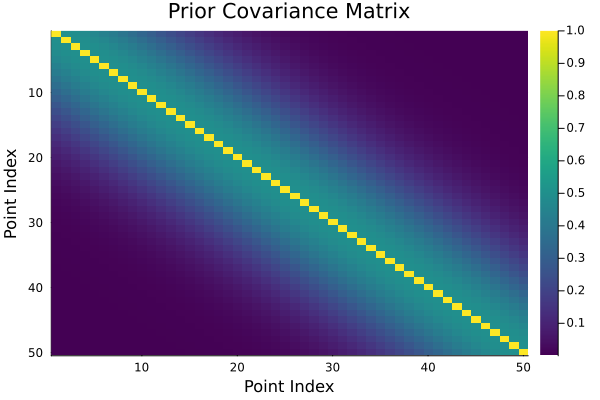

In [29]:
using Plots

# Define the squared exponential kernel with Kronecker delta term
function squared_exponential_with_kronecker(x1, x2, σ²=0.0001, ℓ=1.5)
    delta = ifelse(x1 == x2, 1.0, 0.0)  # Kronecker delta term
    return (1 - σ²) * exp(- (x1 - x2)^2 / (2 * ℓ^2)) + σ² * delta
end

# Generate points
n_points = 50
x = range(0, stop=10, length=n_points)  # Adjust the range and number of points as needed

# Construct the covariance matrix using the custom kernel
σ² = 0.5  # Variance scaling
ℓ = 2    # Length scale
K_prior = [squared_exponential_with_kronecker(x[i], x[j], σ², ℓ) for i in 1:n_points, j in 1:n_points]

# Plot the covariance matrix as a heatmap
heatmap(K_prior, title="Prior Covariance Matrix", xlabel="Point Index", ylabel="Point Index",yflip=true, color=:viridis)
